# Practical Statistics for Data Scientists (Python)
# Chapter 3. Statistial Experiments and Significance Testing
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [55]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [56]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [57]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Resampling

In [58]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

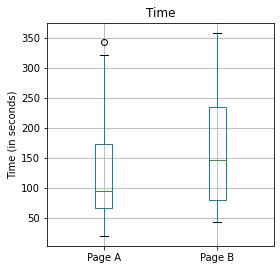

In [59]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

The boxplot, shown in Figure 3-3, indicates that page B leads to longer sessions than page A. The means for each group can be computed as follows:

In [60]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


Page B has session times that are greater than those of page A by 35.67 seconds, on average. The question is `whether this difference is within the range of what random chance might produce, i.e., is statistically significant`.

One way to answer this is to apply a `permutation test`—combine all the session times together and then repeatedly shuffle and divide them into groups of 21 (recall that nA = 21 for page A) and 15 (nB = 15 for page B).

To apply a permutation test, we need a function to randomly assign the 36 session times to a group of 21 (page A) and a group of 15 (page B).
The following code is different to the R version. idx_A and idx_B are reversed.

This function works by sampling (without replacement) nB indices and assigning them to the B group; the remaining nA indices are assigned to group A. The difference between the two means is returned. Calling this function R = 1,000 times and specifying nA = 21 and nB = 15 leads to a distribution of differences in the session times that can be plotted as a histogram.

In [61]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    # P note: this is to create a set of nB(15) random numbers (choosing from population of n (total nA + nB =31 elements))
    idx_A = set(range(n)) - idx_B
    # assign remaining numbers to idx A
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

14.066666666666663


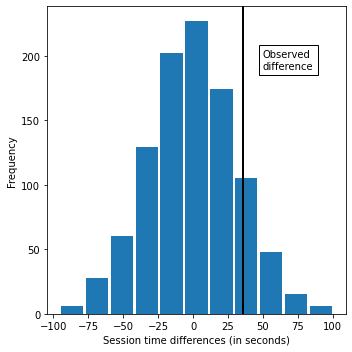

In [62]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
# P note: the black line indicate the diff between mean b and mean a -> they noted as observed difference
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The histogram, in Figure 3-4 shows that mean difference of random permutations often exceeds the observed difference in session times (the vertical line).

print(np.mean(perm_diffs > mean_b - mean_a))
#this will return an errors '>' not supported between instances of 'list' and 'float' because perm_diffs is list, while (mean b, mean a are floats)

In [63]:
np.mean([x for x in perm_diffs if x > (mean_b - mean_a)])
# this result is not inline with 0.121 in the book as it only average the value of item > (mean b - mean a)

52.48272333726879

In [64]:
#learn from syntax below in p-value session
np.mean([ diff > (mean_b - mean_a) for diff in perm_diffs])
#P note: both R and Python use the fact that true is interpreted as 1 and false as 0.
# this will create a list of [1,0,0,1,....,1,1] if this condition is true/false -> the average or mean of this array is the percentage of true over the population

0.121

In [65]:
#P created code to match the result of the book - count the number of time that x > (mean b - mean a)
len([x for x in perm_diffs if x > (mean_b - mean_a)])
#there is 121 items > 35.5

121

In [66]:
#percentage over the mean above out of 1000 samples
print(len([x for x in perm_diffs if x > (mean_b - mean_a)])/1000)

0.121


In [67]:
# pd.DataFrame(perm_diffs).to_csv('checking_perm_diff.csv')
# extract this dataframe to review why the books mention 12.6% -> that is the percentage of samples that > the mean (35.5)

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

P note 2022 Oct 10: Not understand how they concluded this conclusion. There are 12% of the time the sampling of this permutation > the mean of the different observed (35.5) -> this could be attribute by chances (for the significant value of 90%?) -> could not reject the Null hypothesis (that assume the different is attribute by chance) -> This could be a reasonable understanding.

# Statistical Significance and P-Values

The following permutation procedure asks, “If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?”
1. Put cards labeled 1 and 0 in a box: this represents the supposed shared conver‐ sion rate of 382 ones and 45,945 zeros = 0.008246 = 0.8246%.
2. Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
3. Record the number of 1s in the remaining 22,588 (same n as price B).
4. Record the difference in proportion of 1s.
5. Repeat steps 2–4.
6. How often was the difference >= 0.0368?

Observed difference: 0.0368%


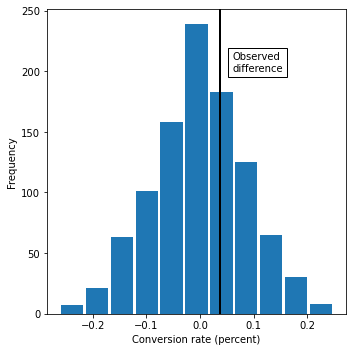

In [68]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## P-Value

We can estimate a p- value from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference:

If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [69]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


The p-value is 0.308, which means that we would expect to achieve a result as extreme as this, or a more extreme result, by random chance over 30% of the time.

In this case, we didn’t need to use a permutation test to get a p-value. Since we have a binomial distribution, we can approximate the p-value. In R code, we do this using the function prop.test.The method scipy.stats.chi2_contingency takes the values as shown in Table 3-2:

In [70]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


The normal approximation yields a p-value of 0.3498, which is close to the p-value obtained from the permutation test.

# t-Tests

In [71]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [72]:
#to review all attribute of res:
dir(res)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'count',
 'index',
 'pvalue',
 'statistic']

In [73]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


# ANOVA

The basis for it can be seen in the follow‐ ing resampling procedure (specified here for the A/B/C/D test of web page stickiness):
1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.
What proportion of the time did the resampled variance exceed the observed var‐ iance? This is the p-value.

In [74]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


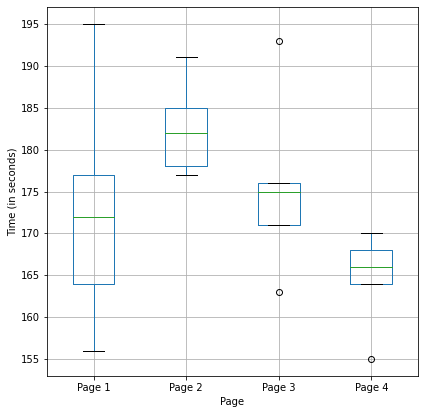

In [75]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(6, 6))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [76]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
42.49333333333322


In [77]:
type(four_sessions.groupby('Page').mean().values)

numpy.ndarray

In [78]:
dir(four_sessions.groupby('Page').mean().values)
#ravel: Return a contiguous flattened array.

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [79]:
four_sessions.groupby('Page').mean().var().squeeze()
#P note: this could be more readable for me than [0]

55.426666666666655

In [80]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

# In Python, we can compute the permutation test using the following code:
    #random.permutation Randomly permute a sequence, or return a permuted range. 
    # np.random.permutation([1, 4, 9, 12, 15])
    # >> array([15,  1,  9,  4, 12])
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
# print(perm_test(four_sessions))
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.08233333333333333


P note following the note in the book to interpret the meaning of the result:<br>
Pr(Prob), is 0.079. In other words, given the same underlying stickiness, 7.9% of the time the response rate among four pages might differ as much as was actually observed, just by chance. This degree of probability > traditional statistical threshold of 5%, so we conclude that the difference among the four pages could have arisen by chance.

Pr(Prob) 0.08266666666666667


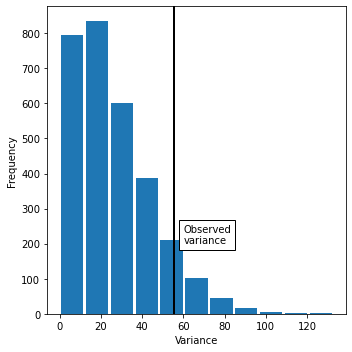

In [81]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
We can compute an ANOVA table using `statsmodel`.
The `statsmodels` package provides an ANOVA implementation in Python:

In [82]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


1. Df is “degrees of freedom,” Sum Sq is “sum of squares,” Mean Sq is “mean squares” (short for mean-squared deviations), and F value is the F-statistic. For the grand average, sum of squares is the departure of the grand average from 0, squared, times 20 (the number of observations). The degrees of freedom for the grand average is 1, by definition.
2. For the treatment means, the degrees of freedom is 3 (once three values are set, and then the grand average is set, the other treatment mean cannot vary). Sum of squares for the treatment means is the sum of squared departures between the treatment means and the grand average.
3. For the residuals, degrees of freedom is 20 (all observations can vary), and SS is the sum of squared difference between the individual observations and the treatment means. Mean squares (MS) is the sum of squares divided by the degrees of freedom.
4. The F-statistic is MS(treatment)/MS(error). The F value thus depends only on this ratio and can be compared to a standard F-distribution to determine whether the differences among treatment means are greater than would be expected in random chance variation.

P note: https://www.scribbr.com/statistics/one-way-anova/ -> more clearly explain the meaning of each result in ANOVA table
The ANOVA output provides an estimate of how much variation in the dependent variable that can be explained by the independent variable.

- The first column lists the independent variable along with the model residuals (aka the model error).
- The Df column displays the degrees of freedom for the independent variable (calculated by taking the number of levels within the variable and subtracting 1), and the degrees of freedom for the residuals (calculated by taking the total number of observations minus 1, then subtracting the number of levels in each of the independent variables).
- The Sum Sq column displays the sum of squares (a.k.a. the total variation) between the group means and the overall mean explained by that variable.
- The Mean Sq column is the mean of the sum of squares, which is calculated by dividing the sum of squares by the degrees of freedom.
- The F-value column is the test statistic from the F test: the mean square of each independent variable divided by the mean square of the residuals. `The larger the F value, the more likely it is that the variation associated with the independent variable is real and not due to chance.`
- The Pr(>F) column is the p-value of the F-statistic. This shows how likely it is that the F-value calculated from the test would have occurred if the null hypothesis of no difference among group means were true.

Another way to run ANOVA one way test:
There are more code related to running code and assumption test at: https://www.pythonfordatascience.org/anova-python/ & https://www.reneshbedre.com/blog/anova.html

In [83]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
# print(f'F-Statistic: {res.statistic / 2:.4f}')
# print(f'p-value: {res.pvalue / 2:.4f}')
# P note: not sure why the original code divided by 2, should not because the result should be equal to method above
print(f'F-Statistic: {res.statistic :.4f}')
print(f'p-value: {res.pvalue :.4f}')

F-Statistic: 2.7398
p-value: 0.0776


- P note 20221015: f_oneway here is not one-tail test. A one-tailed test has the entire 5% of the alpha level in one tail (in either the left, or the right tail). A two-tailed test splits your alpha level in half. As far as I read for ANOVA test, this is alway 1-tail test

Two-Way ANOVA: <br>

The A/B/C/D test just described is a “one-way” ANOVA, in which we have one factor (group) that is varying. We could have a second factor involved—say, “weekend ver‐ sus weekday”—with data collected on each combination (group A weekend, group A weekday, group B weekend, etc.). This would be a “two-way ANOVA,” and we would handle it in similar fashion to the one-way ANOVA by identifying the “interaction effect.” After identifying the grand average effect and the treatment effect, we then separate the weekend and weekday observations for each group and find the differ‐ ence between the averages for those subsets and the treatment average.

### Two-way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Chi-Square Test
## Chi-Square Test: A Resampling Approach

In [84]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


For this test, we need to have the “expected” distribution of clicks, and in this case, that would be under the null hypothesis assumption that all three headlines share the same click rate, for an overall click rate of 34/3,000. Under this assumption, our contingency table would look like Table 3-5.

In [85]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


We can test with this resampling algorithm:
1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed? That’s the p-value.

In [86]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


In [87]:
#P note: this is another way to run Chi square with close same Chi2 value and very close p-value
# From the book: The p-value is a little less than the resampling p-value; this is because the chi-square distribution is only an approximation of the actual distribution of the statistic.
# P note: in R code: chisq.test(clicks, simulate.p.value=FALSE) return exactly this result
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## Figure chi-sq distribution

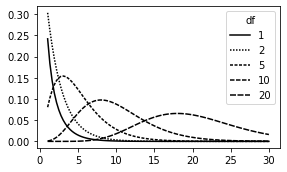

In [88]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## Fisher's Exact Test
Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [89]:
# stats.fisher_exact(clicks.values)

### Scientific Fraud

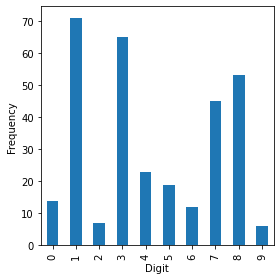

In [90]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

The statsmodels package contains several methods for power calculation. Here, we use proportion_effectsize to calculate the effect size and TTestIndPower to solve for the sample size:

In [91]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [92]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
